Now you feel itself more stronger in understanding dataset. And it means, that we prepare to work with real models!
Below you see:
* How load real models by the ResNet case.
* Create configurate dict with params to ResNet model.
* Distribution of weights from different ResNet models.

If you what to now more about ResNet: 
* [paper](https://arxiv.org/abs/1512.03385)
* [inplementation](https://github.com/analysiscenter/dataset/blob/master/dataset/models/tf/resnet.py)

We prepared for you a surprise, we'll create two, not just one ResNet model!

__First network__ is a simple ResNet that includes five blocks like:

<img src='./pictures/simple_block.png'>

Feature of this network is usage only convolution with kernel 3x3, and skipconnections without convolutions. Skipconnections allows us to increase the depth on the network without meet the vanishing gradients problem. Skipconnections is a main idea of ResNet architecture that really works.

_total weights:_ __617472__

__Second model__ - Resnet with bottlenecks blocks, and each block looks like that:

<img src='./pictures/bottle_block.png'>

In this case we use the 1×1 convolutions layers that responsible for reducing and then increasing (restoring)
dimensions(by change number of filters). This way we decrease the number of parameters almost twice!

_total weights:_ __211712__

In [1]:
import sys

import numpy as np
import seaborn as sns
import tensorflow as tf
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
from tqdm import tqdm_notebook as tqn

sys.path.append('..')
import utils
from dataset import B,V,F
from dataset.dataset.opensets import MNIST
from dataset.dataset.models.tf import ResNet

We will use the MNIST dataset, because it small and simple to use.

In [2]:
dset = MNIST()

DownloadedDownloaded  t10k-labels-idx1-ubyte.gztrain-labels-idx1-ubyte.gz

ExtractingExtracting  /tmp/t10k-labels-idx1-ubyte.gz/tmp/train-labels-idx1-ubyte.gz

Downloaded t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Downloaded train-images-idx3-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz


As simple models, real architectures need the config too.

In [3]:
placeholders_config = {
                       'images': {'shape': (28, 28, 1)},
                
                       'labels': {'classes': (10),
                                  'transform': 'ohe',
                                  'dtype': 'int32',
                                  'name': 'targets'}
                       }

In config we can configurate all params in our model, such as __num_blocks__ in all model, or __filters__.
But you can create model without params, and it will create with default configurations. About ResNet [params](https://analysiscenter.github.io/dataset/api/dataset.models.tf.resnet.html). And about all implement models [here](https://analysiscenter.github.io/dataset/api/dataset.models.html).

In [4]:
ResNet_config = {'inputs': placeholders_config,
                 'input_block/inputs': 'images',
                 'body/num_blocks': [2, 2],
                 'body/filters': [32, 64],
                 'loss': 'softmax_cross_entropy',
                 'optimizer': 'Adam',
            } 
Bottlenet_config = {**ResNet_config,
                          'body/block/bottleneck': 1}

As always don't forget about feed dict

In [5]:
placehold_dict = {'images': B('images'),
                  'labels': B('labels')}

Based on our config to ResNet model, create pipelines and train it.

In [6]:
res_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'resnet',
                      config=ResNet_config)
           .train_model('resnet',
                        feed_dict=placehold_dict))
res_test_ppl = (dset.test
           .p
           .init_variable('resloss', init_on_each_run=list)
           .import_model('resnet', res_tr_ppl)
           .predict_model('resnet',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('resloss'), mode='a'))

Based on another config, we train ResNet model with bottleneck blocks.

In [7]:
bott_tr_ppl = (dset.train
           .p
           .init_model('dynamic',
                      ResNet,
                      'bottle',
                      config=Bottlenet_config)
           .train_model('bottle',
                        feed_dict=placehold_dict))
bott_test_ppl = (dset.test
           .p
           .init_variable('bottloss', init_on_each_run=list)
           .import_model('bottle', bott_tr_ppl)
           .predict_model('bottle',
                        fetches='loss',
                        feed_dict=placehold_dict,
                        save_to=V('bottloss'), mode='a'))

We need to check the quality of ours model during training, for that we going __next_batch__ way to run pipelines.

In [8]:
for i in tqn(range(500)):
    res_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    res_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bott_tr_ppl.next_batch(400, n_epochs=None, shuffle=True)
    bott_test_ppl.next_batch(400, n_epochs=None, shuffle=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


After training we can compare loss-values of both models.

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


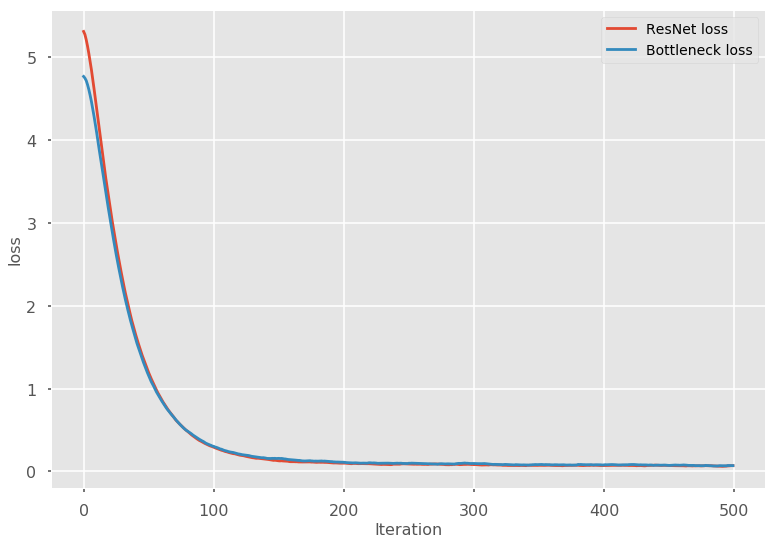

In [17]:
ResNet_loss = res_test_ppl.get_variable('resloss')
Bottle_loss = bott_test_ppl.get_variable('bottloss')
utils.draw(ResNet_loss, 'ResNet', Bottle_loss, 'Bottleneck')

Network with bottleneck architectures has almost half the size of parameters, but training not worse than network with simple model. And bottleneck model train faster, than simple model.

After training you can say, that they accuracy is same, сonsequently there are no difference between networks.
But before summarize it, let's look on the distributions to all weights of two models and after that will be summarize our resuilts.

In [10]:
def get_weights(graph, session):
    """ Get weigths from model
    
    Parameters
    ----------
    graph : tf.Graph
        your model graph
    session : tf.Session
    
    Returns
    -------
    names : list with str
        names of all layers
    weights : np.array
        weights of all layers
    biases : np.array
        biases of all layers
    """
    weights, biases = [], []
    variables = graph.get_collection('trainable_variables')
    variables = [var for var in variables if 'batch_normalization' not in var.name][2:]
    names = np.array([layer.name.split('/')[5] if 'shortcut' not in layer.name else 'shortcut'\
                      for layer in variables[:-2:2]])
    
    weights_variables = [var for var in variables[:-2] if 'bias:0' not in var.name]
    biases_variables = [var for var in variables[:-2] if 'kernel:0' not in var.name]
    weights.append(session.run(weights_variables))
    biases.append(session.run(biases_variables))
    
    return names, np.array(weights[0]), np.array(biases[0])

Load graph out of models and get all weights

In [11]:
bottle_sess = bott_tr_ppl.get_model_by_name("bottle").session
bottle_graph = bottle_sess.graph
bottle_names, bottle_weights, bottle_bias = get_weights(bottle_graph, bottle_sess)

In [12]:
res_sess = res_tr_ppl.get_model_by_name("resnet").session
res_graph = res_sess.graph
res_names, res_weights, res_bias = get_weights(res_graph, res_sess)

Let's count the numbers of parameters on each layer.

In [13]:
bottle_params = np.array([np.array(i.shape).prod() for i in bottle_weights] + [0, 0, 0])
res_params = np.array([np.array(i.shape).prod() for i in res_weights])

Draw the distribution of weights of convolutional layers from Bottleneck ResNet model. All function you can see in [utils](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/utils.py).

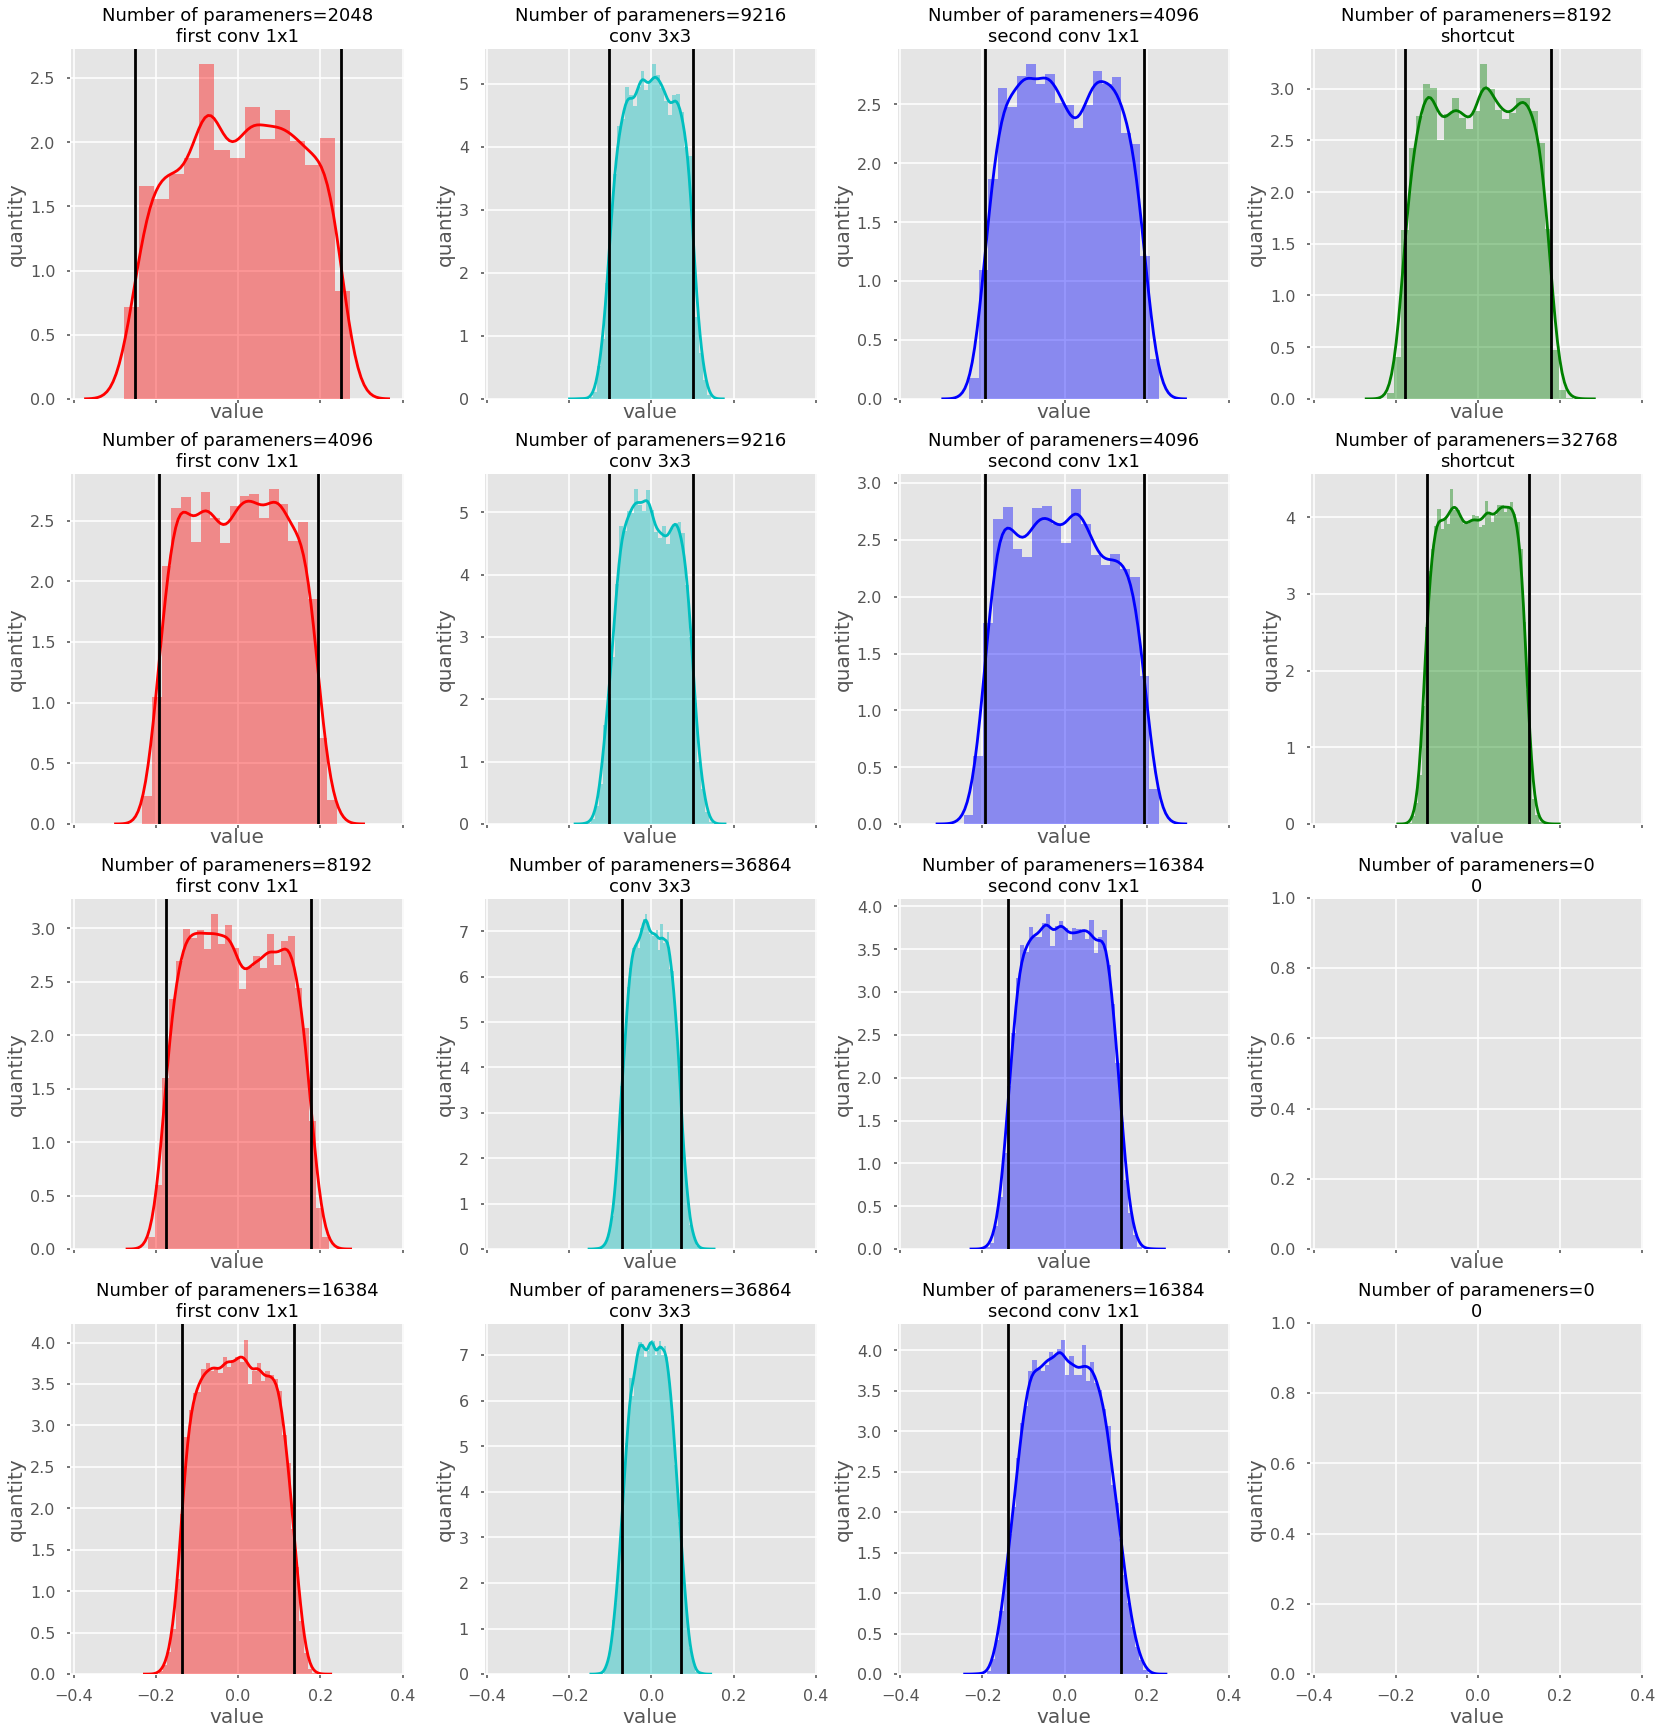

In [14]:
utils.plot_weights(bottle_names, bottle_weights, bottle_params, ['r', 'c', 'b', 'g'], [4, 4])

It's not difficult to notice, that distribution of 1x1 convolutions have a large variance, than convolution 3x3. Therefore, they exert a stronger influence on output.

 __Black lines show the initial distribution of weights__

______

It's time to draw distribution of ResNet model __without__ bottleneck.

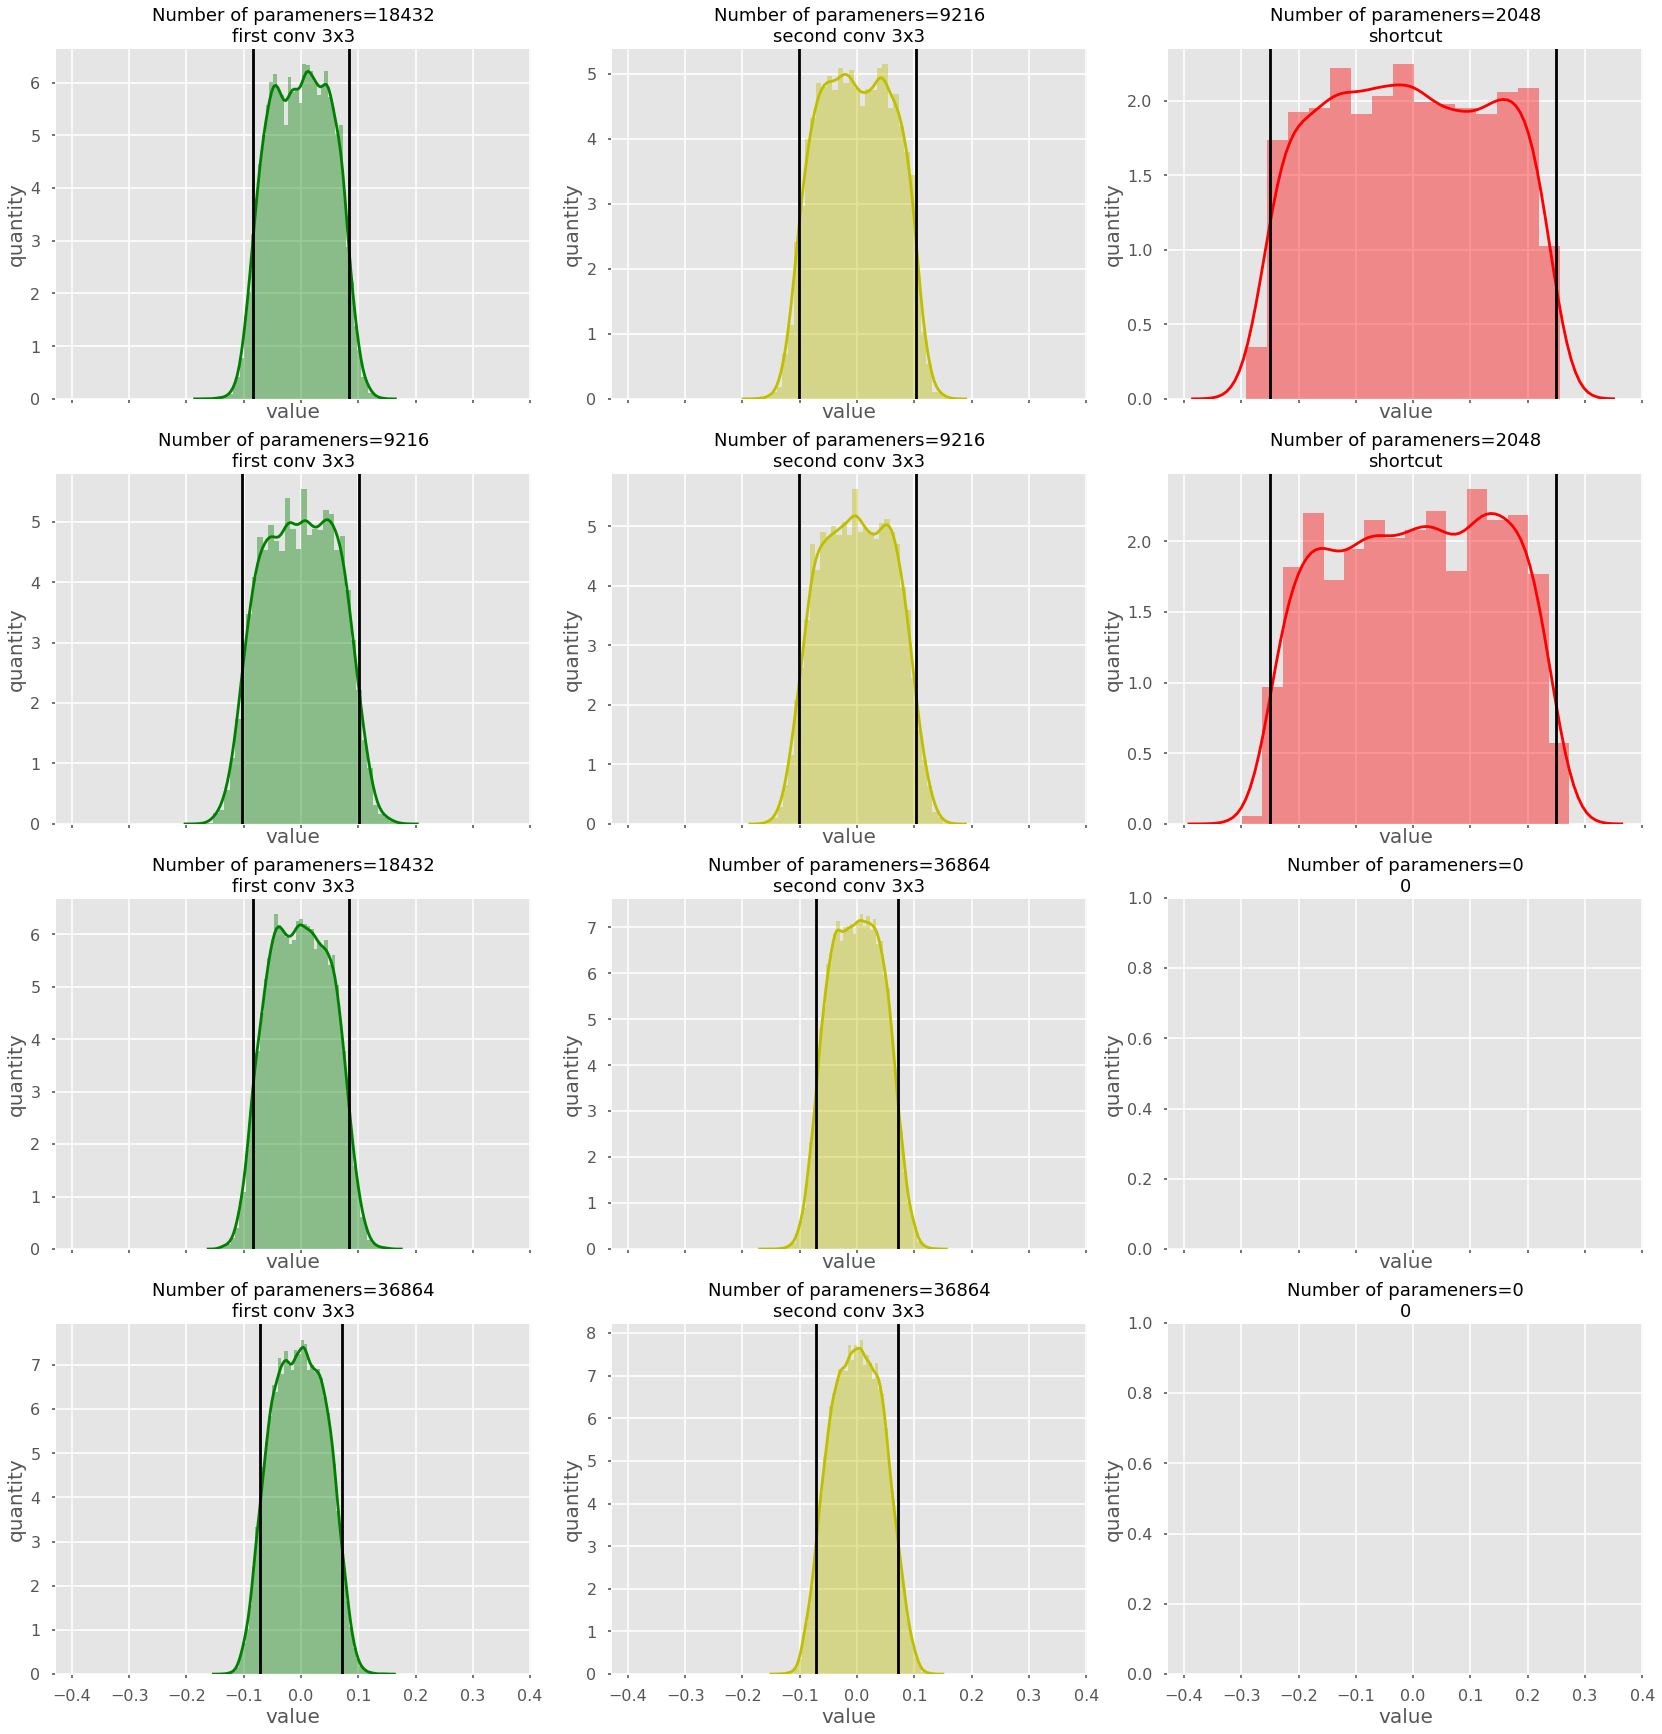

In [15]:
utils.plot_weights(res_names, res_weights, res_params, ['g', 'y', 'r'], [4, 3], bottleneck=False)

looking at the graphs you can see, that distribution of first convolution layers almost did not change, it happend because skipconnection allows change the weights of second convolution layer more than first. Hence, greater in comparison with the first distribution of second layer.

____

Now, let's compare the distribution of second layer of simple ResNet architecture and ResNet with bottlenecks blocks.

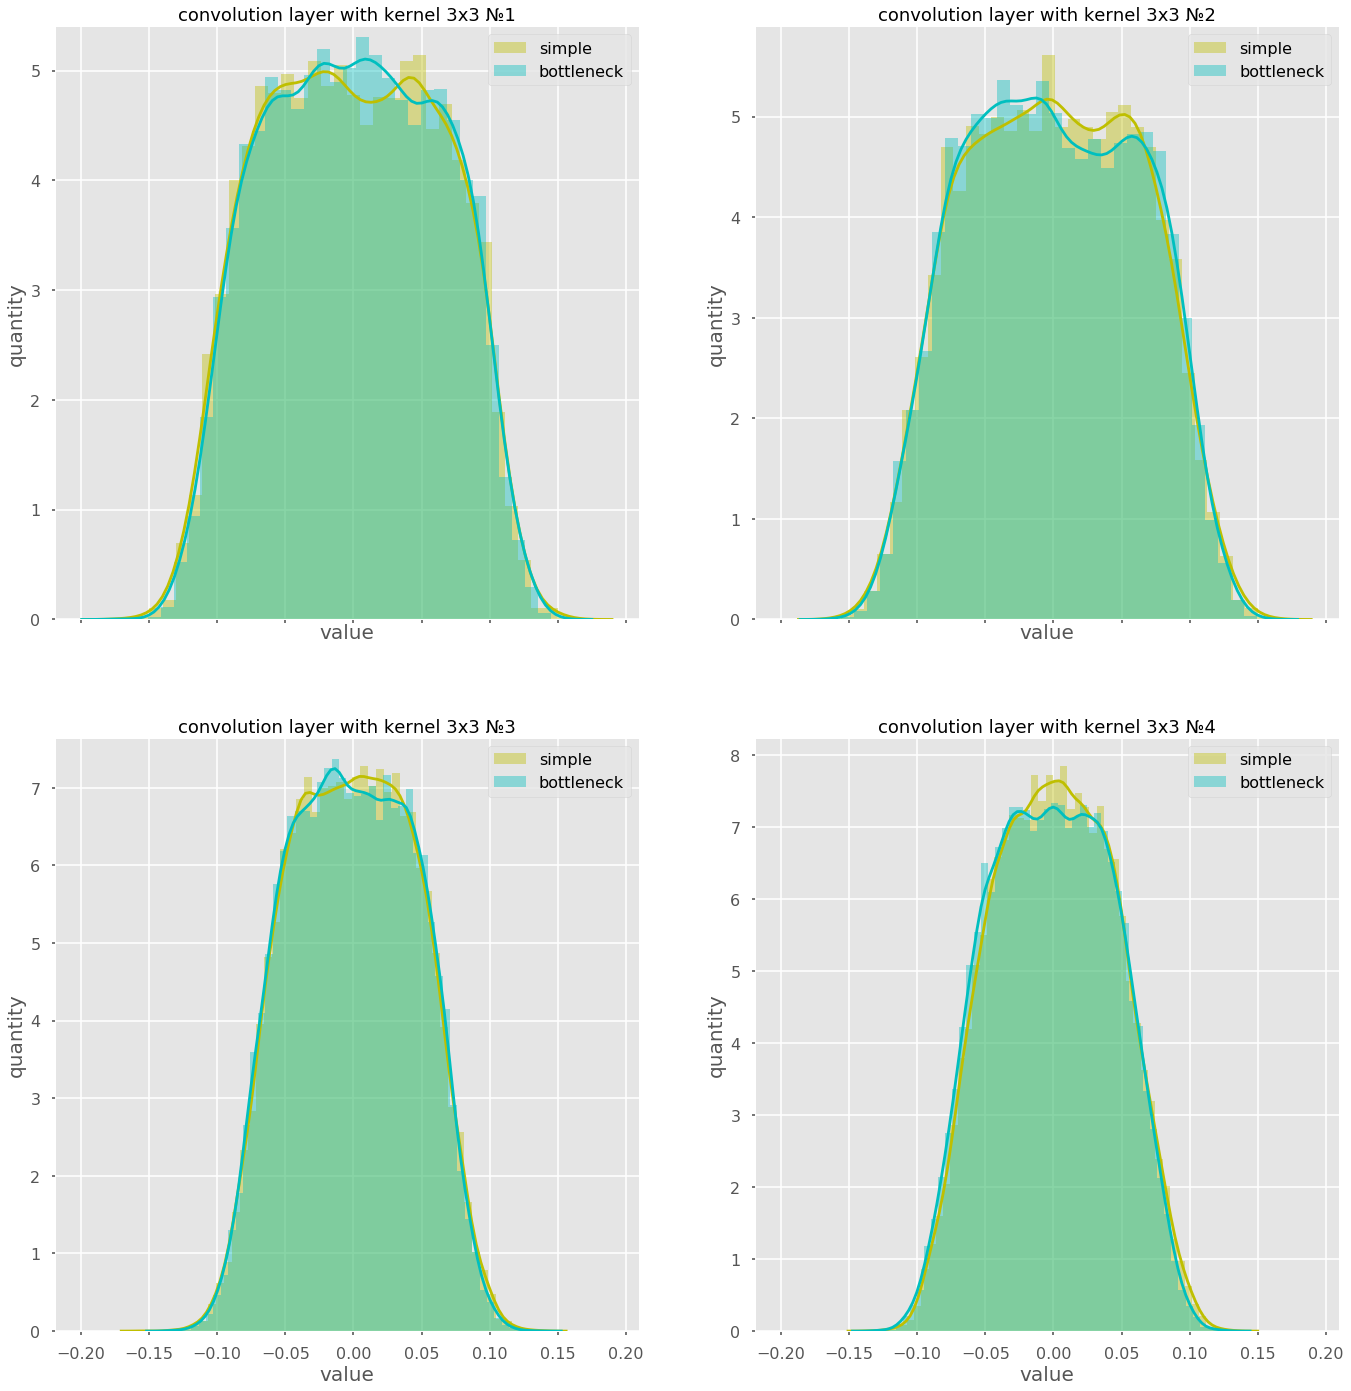

In [16]:
indices = [i for i in range(len(bottle_names)) if 'conv' in bottle_names[i][:8]]
_, ax = plt.subplots(2, 2, sharex='all', figsize=(23, 24))
ax = ax.reshape(-1)
num_plot = 0
for i,j in zip(np.where(res_names == 'layer-3')[0], np.where(bottle_names == 'layer-3')[0]):
    ax[num_plot].set_title('convolution layer with kernel 3x3 №{}'.format(num_plot + 1), fontsize=18)
    sns.distplot(res_weights[i].reshape(-1), ax=ax[num_plot], color='y', label='simple')
    sns.distplot(bottle_weights[j].reshape(-1), ax=ax[num_plot], color='c', label='bottleneck')
    ax[num_plot].legend()
    ax[num_plot].set_xlabel('value', fontsize=20)
    ax[num_plot].set_ylabel('quantity', fontsize=20)
    num_plot += 1
    

Graphs show, that distribution of ResNet with bottleneck block bigger than simple ResNet. It means that convolution 3x3 make smaller effect in train network, than convolutions 1x1. 

### And it's time to conclusions:
1. In this task we learn how use real models with dataset.
2. Now you can configurate you own model.
3. Convolutions with size 1x1 have have fewer parameters and allows train network faster, that with 3x3 convolutions, and 1x1 convolutions may have better quality.
4. Second layer after skipconnection in simple ResNet model have a bigger gradient than first layer and consequently will be train faster.
### And what next?
As you can see, use real model almost does not differ from simple usage of models. We offer you:
* Use ResNet model and train it on MNIST with 3-dimenstions.
* Configurate it with your own wish.
* And goal the score 0.99.

Congratulations you finished all training tasks!
But you can see our research notebooks if you don't see it:
* [zero_weights]()
* [Stochastic_ResNet]()
* [SE_ResNet]()